In [1]:
# --- 1. Import Libraries ---
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv(r"D:\SEM 5\ML\Binary Prediction with a Rainfall Dataset\playground-series-s5e3\train.csv")
test_df = pd.read_csv(r"D:\SEM 5\ML\Binary Prediction with a Rainfall Dataset\playground-series-s5e3\test.csv")
sample_submission_df = pd.read_csv(r"D:\SEM 5\ML\Binary Prediction with a Rainfall Dataset\playground-series-s5e3\sample_submission.csv")
print("Data loaded successfully.")
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Data loaded successfully.
Training data shape: (2190, 13)
Test data shape: (730, 12)


In [3]:
# --- 3. Preprocessing and Feature Engineering ---

# Store test IDs for the final submission file
test_ids = test_df['id']
# Drop the 'id' column as it's not a training feature
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

# Separate features (X) from the target variable (y)
X = train_df.drop('rainfall', axis=1)
y = train_df['rainfall']

# Identify categorical features automatically (any column with 'object' dtype)
categorical_features = X.select_dtypes(include=['object']).columns
print(f"\nIdentified {len(categorical_features)} categorical features: {list(categorical_features)}")

# Apply one-hot encoding to convert categorical features into a numeric format
X = pd.get_dummies(X, columns=categorical_features, dummy_na=False)
test_df = pd.get_dummies(test_df, columns=categorical_features, dummy_na=False)

# --- Crucial Step: Align columns between train and test sets ---
# This ensures both dataframes have the exact same features after one-hot encoding
train_labels = X.columns
test_labels = test_df.columns

missing_in_test = set(train_labels) - set(test_labels)
for c in missing_in_test:
    test_df[c] = 0

missing_in_train = set(test_labels) - set(train_labels)
for c in missing_in_train:
    X[c] = 0

# Ensure the order of columns is identical
test_df = test_df[X.columns]

print("\nPreprocessing complete. Train and test columns are aligned.")
print(f"Shape of processed training data: {X.shape}")
print(f"Shape of processed test data: {test_df.shape}")


Identified 0 categorical features: []

Preprocessing complete. Train and test columns are aligned.
Shape of processed training data: (2190, 11)
Shape of processed test data: (730, 11)


In [4]:
# --- 4. Model Training (LightGBM with Cross-Validation) ---

# Model parameters - these are good starting points for tuning
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'num_leaves': 20,
    'max_depth': 5,
    'seed': 42,
    'n_jobs': -1,
    'verbose': -1,
    'colsample_bytree': 0.7,
    'subsample': 0.7,
}

# Set up Stratified K-Fold cross-validation for robust evaluation
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(test_df))

print(f"\nStarting training with {N_SPLITS}-Fold Cross-Validation...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"--- Fold {fold+1}/{N_SPLITS} ---")
    
    # Split data for the current fold
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    # Initialize and train the model with early stopping
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='auc',
              callbacks=[lgb.early_stopping(100, verbose=False)])
    
    # Store validation predictions (for OOF score)
    oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
    
    # Add test set predictions (will be averaged over all folds)
    test_preds += model.predict_proba(test_df)[:, 1] / N_SPLITS

# Calculate and display the overall Out-of-Fold (OOF) AUC score
oof_auc = roc_auc_score(y, oof_preds)
print(f"\nTraining finished. Overall OOF AUC: {oof_auc:.5f}")


Starting training with 5-Fold Cross-Validation...
--- Fold 1/5 ---
--- Fold 2/5 ---
--- Fold 3/5 ---
--- Fold 4/5 ---
--- Fold 5/5 ---

Training finished. Overall OOF AUC: 0.87157


In [5]:
# --- 5. Generate Submission File ---
submission_df = pd.DataFrame({'id': test_ids, 'rainfall': test_preds})
submission_df.to_csv('submission.csv', index=False)

print("\nSubmission file 'submission.csv' created successfully!")
print(submission_df.head())



Submission file 'submission.csv' created successfully!
     id  rainfall
0  2190  0.851811
1  2191  0.853760
2  2192  0.828361
3  2193  0.498704
4  2194  0.456083


Rainfall Prediction dataset loaded successfully.

Generating EDA plots for Rainfall Prediction Dataset...


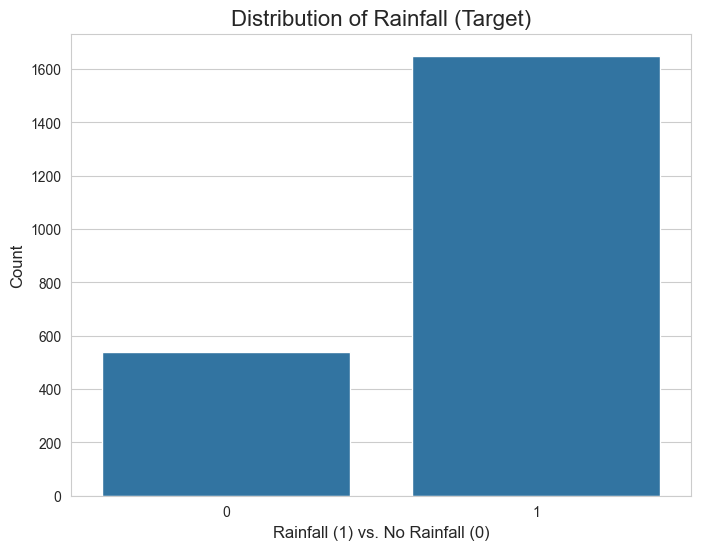


Please update the 'numerical_cols_rain' list with your actual column names.

Skipping Time Series plot: 'date' column not found.

Training a model to get Feature Importance...
[LightGBM] [Info] Number of positive: 1650, number of negative: 540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1632
[LightGBM] [Info] Number of data points in the train set: 2190, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.753425 -> initscore=1.116961
[LightGBM] [Info] Start training from score 1.116961


<Figure size 1200x800 with 0 Axes>

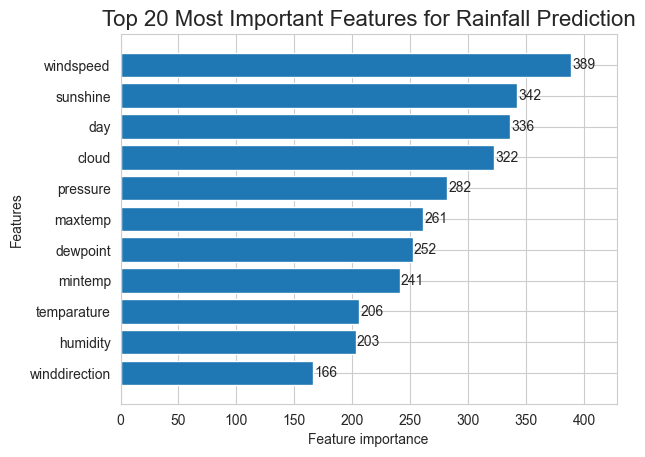

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

# --- 1. Load Data ---
# Ensure the 'train.csv' from the RAINFALL PREDICTION competition is in the same folder.
try:
    df_rain = pd.read_csv(r"D:\SEM 5\ML\Binary Prediction with a Rainfall Dataset\playground-series-s5e3\train.csv")
    print("Rainfall Prediction dataset loaded successfully.")
except FileNotFoundError:
    print("FATAL ERROR: 'train.csv' not found. Please check the file location.")
    exit()

# Set plot style
sns.set_style("whitegrid")

# --- 2. Exploratory Data Analysis (EDA) ---
print("\nGenerating EDA plots for Rainfall Prediction Dataset...")

# Plot 1: Target Variable Distribution (Rainfall)
plt.figure(figsize=(8, 6))
sns.countplot(x='rainfall', data=df_rain)
plt.title('Distribution of Rainfall (Target)', fontsize=16)
plt.xlabel('Rainfall (1) vs. No Rainfall (0)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# Plot 2: Distribution of Key Numerical Weather Features
# ===> ACTION REQUIRED: UPDATE THE COLUMN NAMES IN THE LIST BELOW <===
# Replace these placeholders with the actual numerical column names from your dataset.
numerical_cols_rain = ['Temp_C', 'Relative_Humidity', 'WindSpeed_kmh', 'Air_Pressure'] # <--- CHANGE THESE NAMES

# This code now checks which columns exist before trying to plot them.
existing_cols = [col for col in numerical_cols_rain if col in df_rain.columns]

if existing_cols:
    print(f"Plotting histograms for: {existing_cols}")
    df_rain[existing_cols].hist(bins=30, figsize=(15, 10), layout=(2, 2))
    plt.suptitle('Distribution of Key Numerical Features', fontsize=16)
    plt.show()
else:
    print("\nWarning: None of the specified numerical columns were found in the DataFrame.")
    print("Please update the 'numerical_cols_rain' list with your actual column names.")


# Plot 3: Time Series Plot (if a 'date' column exists)
if 'date' in df_rain.columns:
    print("\nGenerating Time Series plot...")
    df_rain['date'] = pd.to_datetime(df_rain['date'])
    df_rain.set_index('date')['temperature'].plot(figsize=(15, 6), lw=1) # You might need to change 'temperature' here too
    plt.title('Temperature Over Time', fontsize=16)
    plt.ylabel('Temperature', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.show()
else:
    print("\nSkipping Time Series plot: 'date' column not found.")


# --- 3. Model Interpretation (Feature Importance) ---
print("\nTraining a model to get Feature Importance...")

# Basic preprocessing
X = df_rain.drop(['id', 'rainfall'], axis=1, errors='ignore')
y = df_rain['rainfall']
categorical_features = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_features, dummy_na=False)

# Train a simple LightGBM model
model = lgb.LGBMClassifier(random_state=42)
model.fit(X, y)

# Plot 4: Feature Importance
plt.figure(figsize=(12, 8))
lgb.plot_importance(model, max_num_features=20, height=0.8)
plt.title('Top 20 Most Important Features for Rainfall Prediction', fontsize=16)
plt.show()